In [1]:
# These are the main includes used through the notebook
import datetime
import geojson
import numpy as np                   # numeric linear algebra
import matplotlib.pyplot as plt      # plotting
import rasterio       # read/write geotiffs
import tsd            # time series downloader for sentinel and landsat
import utils          # IO and coordinate system conversion tools
import vistools       # display tools
import folium
import folium.plugins
import os

In [13]:
# def get_crop_from_aoi(output_path, aoi, catalog_entry, band):
#     """
#     Crop and download an AOI from a georeferenced image.
#     Args:
#         output_path (string): path to the output GeoTIFF file
#         aoi (geojson.Polygon): area of interest defined by a polygon in longitude, latitude coordinates
#         catalog_entry (tsd.s2_metadata_parser.Sentinel2Image): metadata object
#         band (str): desired band, e.g. 'B04' for Sentinel-2 or 'B8' for Landsat-8
#     """
#     metadata = catalog_entry
#     if not metadata.urls['aws']:
#         metadata.build_s3_links()
#     inpath = metadata.urls['aws'][band]

#     utm_zone = metadata.get("utm_zone")
#     lat_band = metadata.get("lat_band")
#     epsg = tsd.utils.utm_to_epsg_code(utm_zone, lat_band) if utm_zone else None

#     ulx, uly, lrx, lry, epsg = tsd.utils.utm_bbx(aoi, epsg=epsg, r=60)
#     tsd.utils.rasterio_geo_crop(output_path, inpath, ulx, uly, lrx, lry, epsg=epsg)

# new larger image
def get_crop_from_aoi(output_path, aoi, catalog_entry, band):
    """
    Crop and download an expanded AOI from a georeferenced image. The expanded AOI will be twice
    as large as the original area defined by the geojson polygon.
    Args:
        output_path (string): path to the output GeoTIFF file
        aoi (geojson.Polygon): area of interest defined by a polygon in longitude, latitude coordinates
        catalog_entry (tsd.s2_metadata_parser.Sentinel2Image): metadata object
        band (str): desired band, e.g. 'B04' for Sentinel-2 or 'B8' for Landsat-8
    """
    metadata = catalog_entry
    if not metadata.urls['aws']:
        metadata.build_s3_links()
    inpath = metadata.urls['aws'][band]

    utm_zone = metadata.get("utm_zone")
    lat_band = metadata.get("lat_band")
    epsg = tsd.utils.utm_to_epsg_code(utm_zone, lat_band) if utm_zone else None

    # Original bounding box
    ulx, uly, lrx, lry, epsg = tsd.utils.utm_bbx(aoi, epsg=epsg, r=60)

    # Modify bounding box to be twice as large
    # Calculate the center of the original bounding box
    center_x = (ulx + lrx) / 2
    center_y = (uly + lry) / 2
    # Calculate the new bounding box coordinates to make the box twice as large
    new_ulx = ulx - (center_x - ulx)
    new_uly = uly - (center_y - uly)
    new_lrx = lrx + (lrx - center_x)
    new_lry = lry + (lry - center_y)

    # Use the expanded AOI for cropping
    tsd.utils.rasterio_geo_crop(output_path, inpath, new_ulx, new_uly, new_lrx, new_lry, epsg=epsg)


In [3]:
def simple_equalization_8bit(im, percentiles=5):
    ''' im is a numpy array
        returns a numpy array
    '''

    ###     <<< CODE HERE >>>
    low = np.percentile(im, percentiles)
    high = np.percentile(im, 100-percentiles)

    im = np.clip(im, low, high)
    im = (im - low) / (high - low)
    im = np.uint8(im * 255)

    return im

In [4]:
def query_clear_sky(aoi, satellite='Sentinel-2', max_cloud_cover=30,
                    start_date=None, end_date=None):
    '''
    queries the devseed database for the aoi
    returns a filtered catalog with images with cloud
    cover of at most max_cloud_cover
    '''
    # run a search
    if satellite == 'Sentinel-2':
        res = tsd.get_sentinel2.search(aoi, start_date, end_date)
    elif satellite == 'Landsat-8':
        res = tsd.get_landsat.search(aoi, start_date, end_date)


    ###### Insert your solution code here ######
    res2 = []
    for image in res:
      if image.cloud_cover <= max_cloud_cover:
          res2.append(image)

    return res2

In [5]:
def get_sentinel2_color_8bit(basefilename, aoi, catalog_entry, percentiles=5):
    ''' basefilename to store the bands:  basename+BAND+'.tif'
        returns a numpy array of the RGB image (height, width, channels)
    '''
    bands = ['B04', 'B03', 'B02']    # SENTINEL2 R,G,B BANDS

    # this command downloads all the bands
    for b in bands:
        get_crop_from_aoi('{}_{}.tif'.format(basefilename, b), aoi, catalog_entry, b)

    # read, equalize, and stack all the channels
    out = []
    for b in bands:
        im = utils.readGTIFF('{}_{}.tif'.format(basefilename, b))
        im = simple_equalization_8bit(im, percentiles)
        out.append(im)

    # The transposition is necessary because the indexing
    # convention for color images is (height, width, channels)
    im = np.squeeze(out,axis=(3)).transpose(1,2,0)
    return im

In [6]:
def get_sentinel2_image(geojsonstring, start_date, end_date, max_cloud_cover=30, percentiles=5, satellite='Sentinel-2', path='.'):
    ''' returns a numpy array of the RGB image (height, width, channels)
    '''
    # pick the satellite then query the database
    aoi = utils.find_key_in_geojson(geojson.loads(geojsonstring),'geometry')
    basename = 'rgb'
    res = query_clear_sky(aoi, satellite, max_cloud_cover, start_date, end_date)

    # generate the RGB image
    RGBout = get_sentinel2_color_8bit(basename, aoi, res[-1], percentiles)

    # Writes RGBout in 'rgb_RGB.tif' copying geolocation metadata from 'rgb_B03.tif',
    # which has been written by    get_sentinel2_color_8bit
    utils.writeGTIFF(RGBout, path+'.tif', basename+'_B03.tif')
    
    # delete the intermediate files
    for b in ['B02', 'B04', 'B03']:
        os.remove('{}_{}.tif'.format(basename, b))

    return RGBout

In [15]:
import json

with open('landfills_openstreetmap.geojson') as f:
    data = json.load(f)
    
geojsonstring = str(data['features'][0])
geojsonstring = geojsonstring.replace("'", '"')

Found 71 images


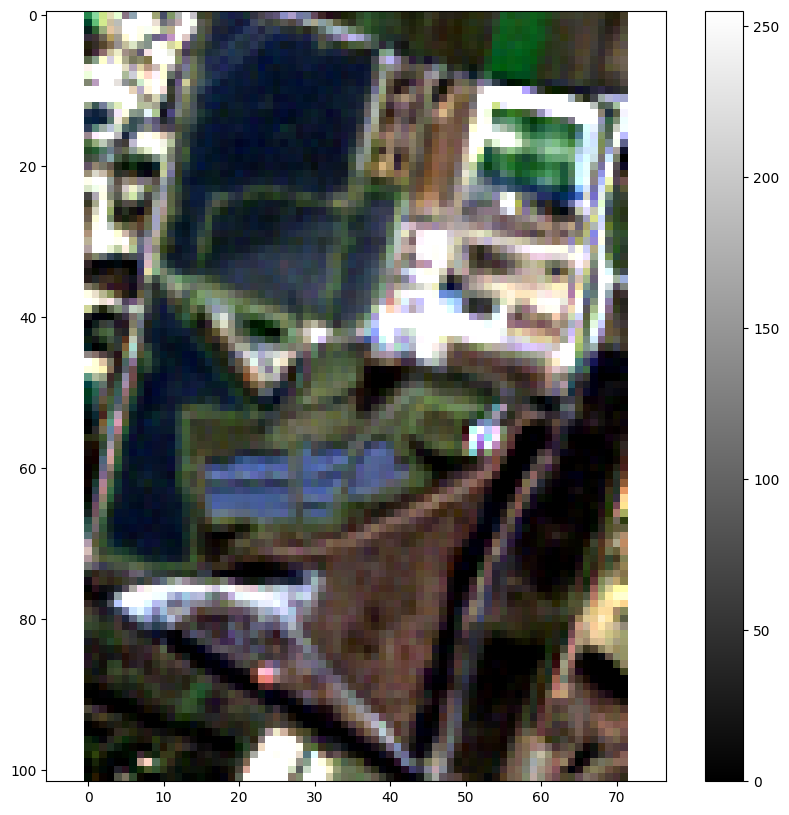

In [16]:
start_date = datetime.datetime(2023, 7, 1)
end_date = datetime.datetime(2023, 12, 31)
RGBout = get_sentinel2_image(geojsonstring, start_date=start_date, end_date=end_date, max_cloud_cover=10, percentiles=5, satellite='Sentinel-2', path='dataset/0')

# Display the RGB image
vistools.display_imshow(RGBout, figsize=(10,10))

In [17]:
start_date = datetime.datetime(2023, 7, 1)
end_date = datetime.datetime(2023, 12, 31)
for i in range(5):
    try :
        geojsonstring = str(data['features'][i])
        geojsonstring = geojsonstring.replace("'", '"')
        RGBout = get_sentinel2_image(geojsonstring, start_date=start_date, end_date=end_date, max_cloud_cover=10, percentiles=5, satellite='Sentinel-2', path='large_dataset/large'+str(i))
        if i%10 == 0:
            print('large'+str(i), 'done')
    except:
        print('large'+str(i), 'failed')
        continue

Found 71 images
dataset/large0 done
Found 70 images
Found 68 images
Found 73 images
Found 73 images


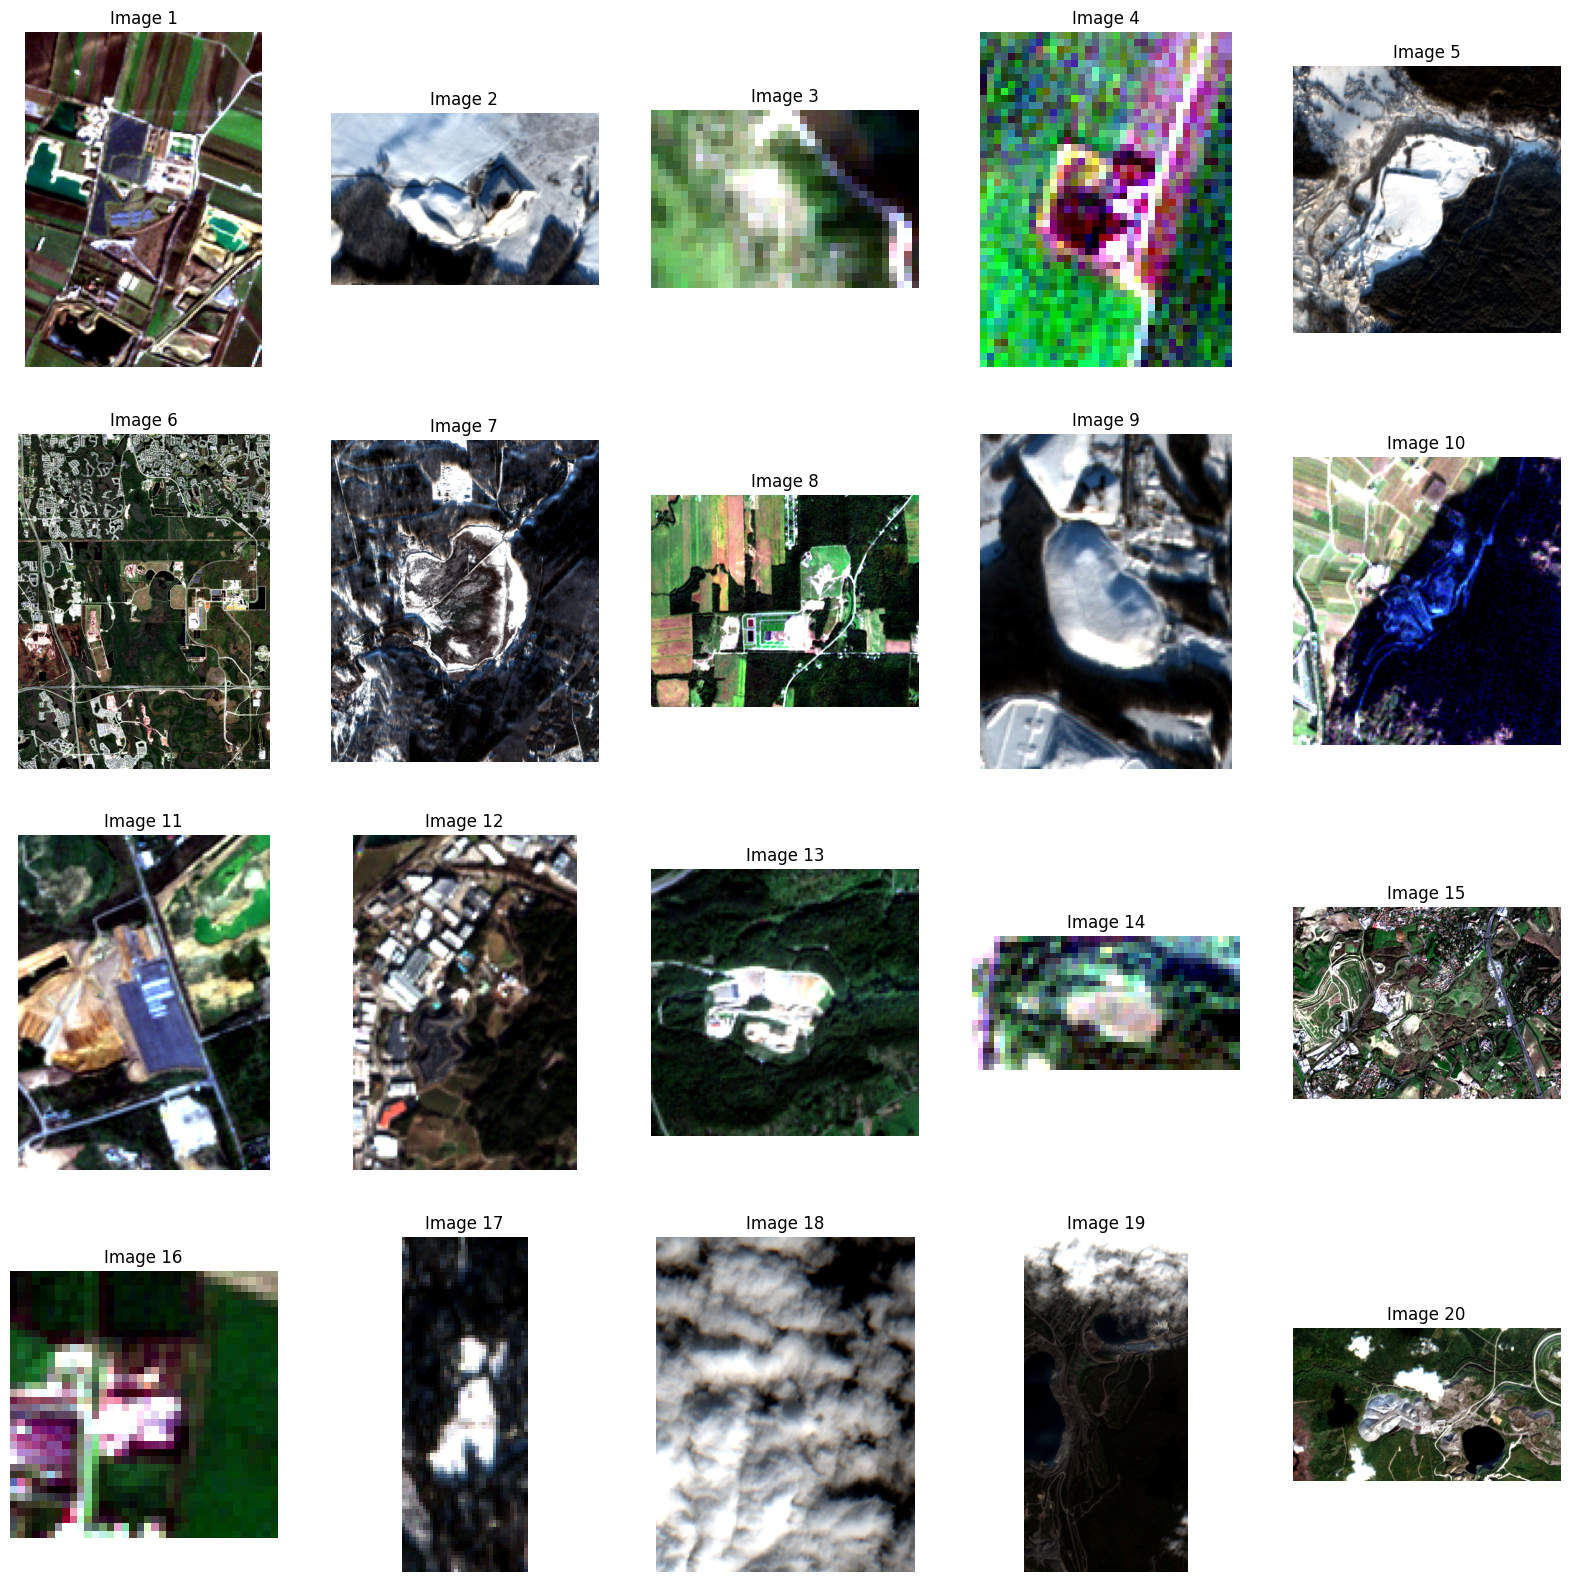

In [12]:
# show the first 20 images
fig, axes = plt.subplots(4, 5, figsize=(20, 20))
for i in range(20):
    RGB = rasterio.open('large_dataset/large'+str(i)+'.tif')
    # to numpy array
    RGB = RGB.read()
    axes[i//5, i%5].imshow(RGB.transpose(1, 2, 0))
    axes[i//5, i%5].axis('off')
    axes[i//5, i%5].set_title('Image '+str(i+1))

### Quelques tests

In [9]:
# list all files in the directory
images_tif = os.listdir('large_dataset')
len(images_tif)

7775

In [19]:
def get_image_longlat_polygon(filename):
    '''
    receives a GeoTIFF filename. Determines the image size
    and computes the long/lat coordinates of the four image corners.
    returns a GeoJSON polygon with the four corners
    '''
    # get the image size
    A = utils.readGTIFFmeta(filename)
    H = int(A[0]['height'])
    W = int(A[0]['width'])

    cols = [0,W,W,0]
    rows = [0,0,H,H]

    ###     <<< COMPLETE THE CODE >>>
    coords = utils.gdal_get_longlat_of_pixel(filename, cols, rows)

    # remove the altitude (which is 0)
    coords = [ [x[0], x[1]] for x in coords ]

    polygon = {'type': 'Polygon', 'coordinates': [coords]}
    return polygon

In [20]:
#### Test the function by running
fname = 'dataset/large5.tif'

footprint = get_image_longlat_polygon(fname)

# create a map cetered at location indicated by its (latitude, longitude)
m = vistools.foliummap(location = footprint[ 'coordinates'][0][0][::-1],
                       zoom_start = 13 )
# and display the footprint polygon
folium.GeoJson(footprint).add_to(m)

display(m)

RUN: gdaltransform -t_srs +proj=longlat dataset/large5.tif [x y from stdin]


In [31]:
# show polygon 5 of the geojson file
footprint = data['features'][5]['geometry']
m = vistools.foliummap(location = footprint[ 'coordinates'][0][0][::-1],
                       zoom_start = 13 )
# and display the footprint polygon
folium.GeoJson(footprint).add_to(m)

display(m)

In [38]:
import os
import subprocess

def gdal_get_pixel_of_longlat(fname, longlat, verbose=True):
    """
    returns the pixel coordinates for the points at longitude and latitude 
    (assuming a default altitude wrt the WGS84 reference ellipsoid) in the GeoTIFF image fname. 
    The CRS of the input GeoTIFF is determined from the metadata in the file.
    """
    # add vsicurl prefix if needed
    env = os.environ.copy()
    if fname.startswith(('http://', 'https://')):
        env['CPL_VSIL_CURL_ALLOWED_EXTENSIONS'] = fname[-3:]
        fname = '/vsicurl/{}'.format(fname)

    # form the query string for gdaltransform
    q = b''
    for coords in longlat:
        if len(coords) == 2:  # Only longitude and latitude provided
            coords = (*coords, 0)  # Append a default altitude of 0
        q = q + b'%f %f %f\n' % coords  # Unpack the tuple directly

    # call gdaltransform to convert longlat to pixel coordinates, -i does the inverse transformation
    cmdlist = ['gdaltransform', '-t_srs', "+proj=longlat", '-i', fname]
    if verbose:
        print('RUN: ' + ' '.join(cmdlist) + ' [long lat [alt] from stdin]')
    p = subprocess.Popen(cmdlist, env=env, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out, err = p.communicate(q)
    if p.returncode != 0:
        raise RuntimeError("Command failed: %s\nError message: %s" % (' '.join(cmdlist), err.decode()))

    # parse the output from gdaltransform to get pixel coordinates
    listeout = [list(map(float, x.split())) for x in out.decode().splitlines()]
    return listeout


RUN: gdaltransform -t_srs +proj=longlat -i dataset/5.tif [long lat [alt] from stdin]


(-25.522874993806923, 511.7597721166351, 682.5278952959571, -0.5)

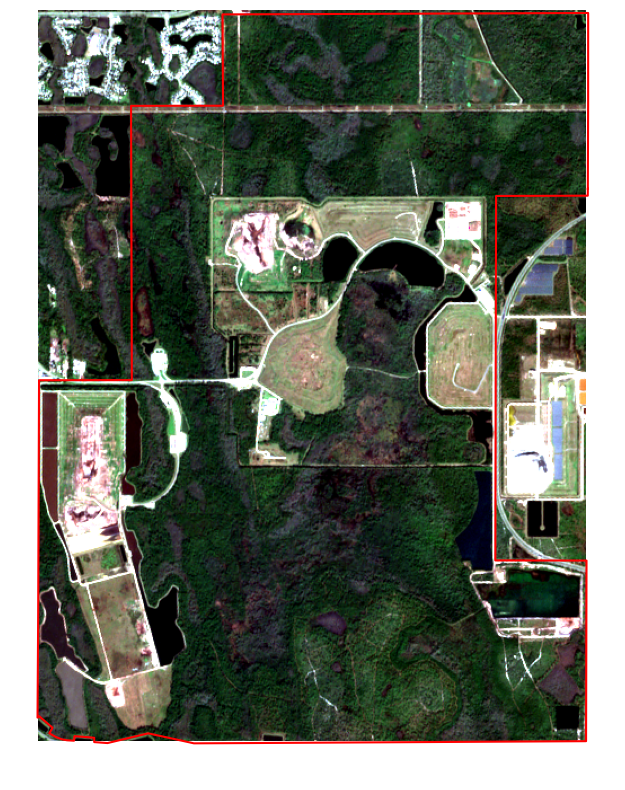

In [40]:
# get all the pixel coordinates of the points in the polygon
fname = 'dataset/5.tif'
polygon = data['features'][5]['geometry']['coordinates'][0]
# transform the polygon to pixel coordinates
polygon = gdal_get_pixel_of_longlat(fname, polygon)

# show the points in the image
RGB = rasterio.open(fname)
RGB = RGB.read()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(RGB.transpose(1, 2, 0))
ax.plot([x[0] for x in polygon], [x[1] for x in polygon], 'r-')
ax.axis('off')

